
# Prédiction de la solubilité aqueuse (ESOL) – Projet pas à pas

Ce notebook montre **pas à pas**, de manière simple, comment :
- charger des données chimiques (ESOL)
- nettoyer les molécules
- transformer les molécules en nombres
- entraîner un modèle de machine learning
- évaluer ses performances
- interpréter les résultats

Le but est **comprendre ce que l’on fait**, pas juste faire tourner du code.


## 🛠️ Installation des dépendances

Avant d’exécuter le notebook, il est nécessaire d’installer les bibliothèques utilisées dans ce projet.

Dans un terminal, place-toi dans le dossier du projet puis exécute la commande suivante :

```bash
pip install -r requirements.txt


## 1. Importation des bibliothèques


On importe ici toutes les bibliothèques nécessaires :
- `pandas`, `numpy` : manipulation des données
- `matplotlib` : visualisation
- `RDKit` : chimie (SMILES, descripteurs, fingerprints)
- `scikit-learn` : machine learning


In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.Chem import rdFingerprintGenerator

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


## 2. Chargement des données ESOL


Le fichier `esol.csv` contient :
- des SMILES (structures moléculaires)
- la solubilité expérimentale (logS)

C’est cette valeur expérimentale que l’on cherche à prédire.


In [ ]:

df = pd.read_csv("esol.csv")
target_col = "measured log solubility in mols per litre"

print("Nombre de molécules :", len(df))
df.head()


Nombre de molécules : 1128


,Compound ID,ESOL predicted log solubility in mols per litre,Minimum Degree,Molecular Weight,Number of H-Bond Donors,Number of Rings,Number of Rotatable Bonds,Polar Surface Area,measured log solubility in mols per litre,smiles
0,Amigdalin,-0.974,1,457.432,7,3,7,202.32,-0.77,OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)...
1,Fenfuram,-2.885,1,201.225,1,2,2,42.24,-3.30,Cc1occc1C(=O)Nc2ccccc2
2,citral,-2.579,1,152.237,0,0,4,17.07,-2.06,CC(C)=CCCC(C)=CC(=O)
3,Picene,-6.618,2,278.354,0,5,0,0.00,-7.87,c1ccc2c(c1)ccc3c2ccc4c5ccccc5ccc43
4,Thiophene,-2.232,2,84.143,0,1,0,0.00,-1.33,c1ccsc1


## 3. Vérification et nettoyage chimique


Avant toute chose, on vérifie que :
- les SMILES sont valides
- il n’y a pas de sels ou mélanges (SMILES avec un point)

C’est une étape **très importante** en chimie.


In [3]:

df["mol"] = df["smiles"].apply(Chem.MolFromSmiles)

# Supprimer les molécules invalides
df = df[df["mol"].notnull()]

# Supprimer les sels / mélanges
df = df[df["smiles"].apply(lambda x: "." not in x)]

print("Molécules après nettoyage :", len(df))


Molécules après nettoyage : 1128


## 4. Analyse de la solubilité expérimentale


On regarde la distribution de la solubilité (logS).
Cela permet de comprendre :
- si les données sont équilibrées
- quelles valeurs sont les plus fréquentes


In [4]:

df[target_col].describe()


count    1128.000000
mean       -3.050102
std         2.096441
min       -11.600000
25%        -4.317500
50%        -2.860000
75%        -1.600000
max         1.580000
Name: measured log solubility in mols per litre, dtype: float64

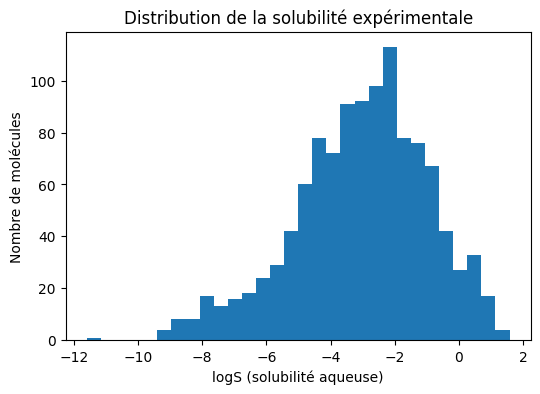

In [5]:

plt.figure(figsize=(6,4))
plt.hist(df[target_col], bins=30)
plt.xlabel("logS (solubilité aqueuse)")
plt.ylabel("Nombre de molécules")
plt.title("Distribution de la solubilité expérimentale")
plt.show()


## 5. Calcul des descripteurs moléculaires


Les descripteurs sont des propriétés simples :
- masse moléculaire
- polarité
- liaisons hydrogène
- flexibilité

Ils ont un sens chimique clair.


In [6]:

descriptor_funcs = {
    "MolWt": Descriptors.MolWt,
    "LogP": Descriptors.MolLogP,
    "TPSA": Descriptors.TPSA,
    "HBD": Descriptors.NumHDonors,
    "HBA": Descriptors.NumHAcceptors,
    "RotB": Descriptors.NumRotatableBonds,
    "Rings": Descriptors.RingCount
}

for name, func in descriptor_funcs.items():
    df[name] = df["mol"].apply(func)

X_desc = df[list(descriptor_funcs.keys())].values


## 6. Calcul des empreintes de Morgan (fingerprints)


Les fingerprints de Morgan décrivent la **structure** de la molécule.
Elles sont très utilisées en chimio-informatique.

Ici :
- rayon = 2
- taille = 1024 bits (plus stable pour la mémoire)


In [7]:

morgan_gen = rdFingerprintGenerator.GetMorganGenerator(
    radius=2,
    fpSize=1024
)

def morgan_fp(mol):
    return np.array(morgan_gen.GetFingerprint(mol))

X_fp = np.vstack(df["mol"].apply(morgan_fp))


## 7. Construction des données finales


On combine :
- les descripteurs (interprétables)
- les fingerprints (performance)

Puis on prépare la variable cible (logS).


In [8]:

X = np.hstack([X_desc, X_fp])
y = df[target_col].values

print("Dimension de X :", X.shape)


Dimension de X : (1128, 1031)


## 8. Séparation entraînement / test


On sépare les données :
- 80 % pour entraîner le modèle
- 20 % pour tester ses performances


In [9]:

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


## 9. Entraînement du modèle


On utilise une **Random Forest** :
- robuste
- non linéaire
- bien adaptée aux données chimiques


In [10]:

model = RandomForestRegressor(
    n_estimators=100,
    random_state=42,
    n_jobs=-1
)

model.fit(X_train, y_train)


,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",100
,"criterion criterion: {""squared_error"", ""absolute_error"", ""friedman_mse"", ""poisson""}, default=""squared_error""The function to measure the quality of a split. Supported criteriaare ""squared_error"" for the mean squared error, which is equal tovariance reduction as feature selection criterion and minimizes the L2loss using the mean of each terminal node, ""friedman_mse"", which usesmean squared error with Friedman's improvement score for potentialsplits, ""absolute_error"" for the mean absolute error, which minimizesthe L1 loss using the median of each terminal node, and ""poisson"" whichuses reduction in Poisson deviance to find splits.Training using ""absolute_error"" is significantly slowerthan when using ""squared_error""... versionadded:: 0.18 Mean Absolute Error (MAE) criterion... versionadded:: 1.0 Poisson criterion.",'squared_error'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",None
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=1.0The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None or 1.0, then `max_features=n_features`... note:: The default of 1.0 is equivalent to bagged trees and more randomness can be achieved by setting smaller values, e.g. 0.3... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to 1.0.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",1.0
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsample

## 10. Évaluation du modèle


On évalue le modèle avec :
- RMSE : erreur globale
- MAE : erreur moyenne
- R² : qualité de la prédiction (plus proche de 1 = mieux)


In [11]:

y_pred = model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"RMSE : {rmse:.3f}")
print(f"MAE  : {mae:.3f}")
print(f"R²   : {r2:.3f}")


RMSE : 0.788
MAE  : 0.547
R²   : 0.869


## 11. Comparaison valeurs réelles / prédites


Ce graphique montre :
- la solubilité expérimentale (axe x)
- la solubilité prédite (axe y)

Plus les points sont proches de la diagonale, meilleur est le modèle.


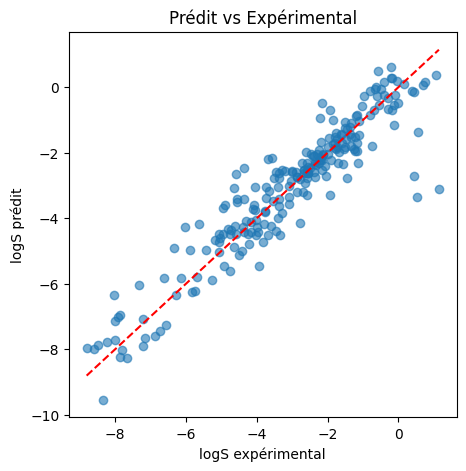

In [12]:

plt.figure(figsize=(5,5))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()], 'r--')
plt.xlabel("logS expérimental")
plt.ylabel("logS prédit")
plt.title("Prédit vs Expérimental")
plt.show()


## 12. Prédiction sur de nouvelles molécules


On peut maintenant prédire la solubilité de molécules **qui ne sont pas dans ESOL**.
Ces valeurs sont des **prédictions**, pas des mesures expérimentales.


In [13]:

new_smiles = ["CCO", "c1ccccc1", "CC(=O)O", "CCN(CC)CCO"]
new_mols = [Chem.MolFromSmiles(s) for s in new_smiles]

new_desc = np.array([[func(m) for func in descriptor_funcs.values()] for m in new_mols])
new_fp = np.vstack([morgan_fp(m) for m in new_mols])
new_X = np.hstack([new_desc, new_fp])

pd.DataFrame({
    "SMILES": new_smiles,
    "logS prédit": model.predict(new_X)
})


,SMILES,logS prédit
0,CCO,0.940200
1,c1ccccc1,-1.703600
2,CC(=O)O,0.717600
3,CCN(CC)CCO,0.384575



## Conclusion

Le modèle :
- apprend des tendances chimiques réalistes
- prédit correctement les molécules polaires comme solubles
- donne des valeurs plausibles pour des molécules hydrophobes

Ce travail montre comment le machine learning peut aider à comprendre
et prédire des propriétés chimiques réelles.
